In [1]:
# @title 1. Setup and Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from google.colab import drive
import cv2

# Configuration to respect Colab Free limits
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 20
SEED = 42

print(f"TensorFlow Version: {tf.__version__}")
if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is available and will be used.")
else:
    print("⚠️ GPU not detected. Training will be slow.")

TensorFlow Version: 2.19.0
✅ GPU is available and will be used.


In [4]:
# @title 2. Data Loading & Handling Imbalance
# Mount Google Drive
drive.mount('/content/drive')

# ❗ UPDATE THIS PATH to your actual dataset location in Drive
# Example: '/content/drive/MyDrive/Datasets/MyImageDataset'
DATASET_PATH = '/content/drive/MyDrive/dataset'

# Check if path exists
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Path not found: {DATASET_PATH}. Please check your Drive path.")

# Create Datasets using tf.data (efficient for Colab)
# We split 80% Train, 10% Validation, 10% Test
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Further split Validation into Val (50%) and Test (50%) -> (10% total each)
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

class_names = train_ds.class_names
print(f"Classes detected: {class_names}")

# --- Handle Class Imbalance ---
# We compute class weights to pass to the model training
y_train = []
for images, labels in train_ds.unbatch():
    y_train.append(labels.numpy())
y_train = np.array(y_train)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights computed: {class_weights_dict}")

# Optimization for performance (Prefetching)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 13331 files belonging to 3 classes.
Using 10665 files for training.
Found 13331 files belonging to 3 classes.
Using 2666 files for validation.
Classes detected: ['test', 'train', 'val']
Class Weights computed: {0: np.float64(2.508821453775582), 1: np.float64(0.5024024872809497), 2: np.float64(1.6367403314917126)}


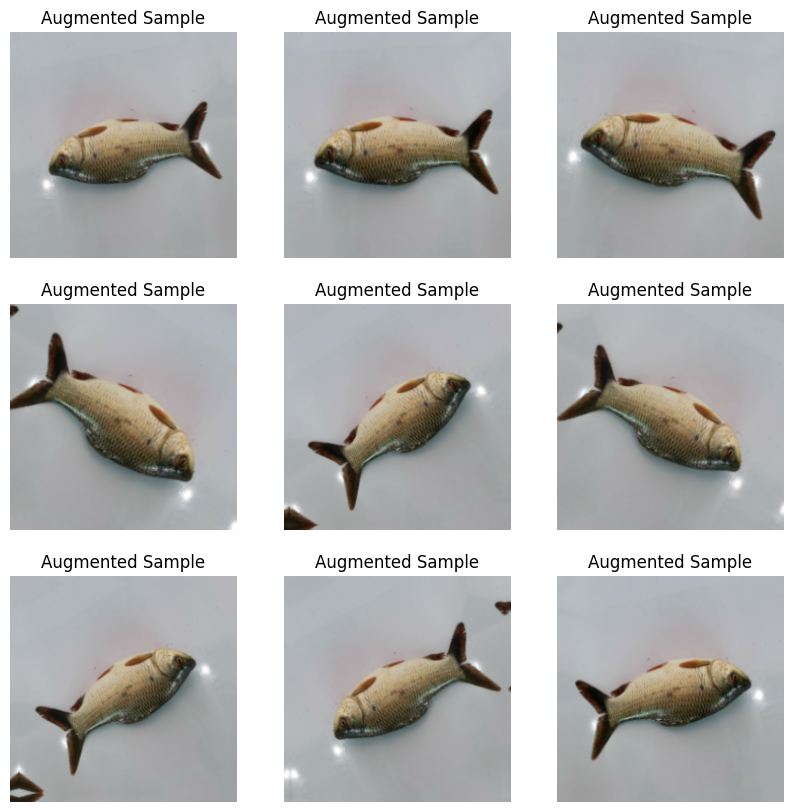

In [5]:
# @title 3. Augmentation Pipeline
# Sequential model for augmentation (runs on GPU)
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
])

def plot_augmentation(dataset):
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")
            plt.title("Augmented Sample")
    plt.show()

# Visualize
plot_augmentation(train_ds)

In [10]:
# @title 4. Custom CNN Model
def build_custom_cnn(input_shape, num_classes):
    model = models.Sequential([
        # Rescaling layer (Preprocessing)
        layers.Rescaling(1./255, input_shape=input_shape),

        # Augmentation (Active only during training)
        data_augmentation,

        # Block 1
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3), # Regularization

        # Dense Top
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model_scratch = build_custom_cnn(IMG_SIZE + (3,), len(class_names))
model_scratch.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_scratch.summary()

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history_scratch = model_scratch.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights_dict, # Handling imbalance
    callbacks=[early_stop]
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,043 (433.76 KB)

 Trainable params: 110,595 (432.01 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 50s 141ms/step - accuracy: 0.3138 - loss: 1.2463 - val_accuracy: 0.1770 - val_loss: 1.1286
Epoch 2/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 46s 139ms/step - accuracy: 0.3679 - loss: 1.1131 - val_accuracy: 0.2050 - val_loss: 1.1285
Epoch 3/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 47s 140ms/step - accuracy: 0.2739 - loss: 1.1206 - val_accuracy: 0.6104 - val_loss: 1.0582
Epoch 4/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 47s 140ms/step - accuracy: 0.3899 - loss: 1.1018 - val_accuracy: 0.1838 - val_loss: 1.1244
Epoch 5/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 47s 140ms/step - accuracy: 0.2801 - loss: 1.0966 - val_accuracy: 0.4032 - val_loss: 1.1016
Epoch 6/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 47s 140ms/step - accuracy: 0.2667 - loss: 1.1007 - val_accuracy: 0.2292 - val_loss: 1.1207
Epoch 7/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 47s 139ms/step - accuracy: 0.3151 - loss: 1.0869 - val_accuracy: 0.2814 - val_loss: 1.1013
Epoch 8/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 46s 138ms/step - accuracy: 0.2279 - loss: 1

In [11]:
# @title 5. Transfer Learning (MobileNetV2)
# Using MobileNetV2 as it is lightweight and efficient for Colab
base_model = applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model.trainable = False

# Build Model
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = layers.Rescaling(1./127.5, offset=-1)(inputs) # MobileNet specific preprocessing
x = data_augmentation(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model_tl = models.Model(inputs, outputs)

# Compile
model_tl.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_tl.summary()

# Train Phase 1 (Frozen Base)
history_tl = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10, # Fewer epochs for initial phase
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

# Phase 2: Fine-tuning
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model_tl.compile(optimizer=optimizers.Adam(learning_rate=1e-5), # Lower LR
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train Phase 2 (Fine-tuning)
history_tl_finetune = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    initial_epoch=history_tl.epoch[-1],
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - accuracy: 0.3347 - loss: 1.3070 - val_accuracy: 0.2716 - val_loss: 1.2026
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.3377 - loss: 1.1914 - val_accuracy: 0.5280 - val_loss: 0.9945
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.3407 - loss: 1.1963 - val_accuracy: 0.2943 - val_loss: 1.1618
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.3617 - loss: 1.1339 - val_accuracy: 0.1725 - val_loss: 1.3399
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.3502 - loss: 1.1482 - val_accuracy: 0.4463 - val_loss: 1.0543
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.3639 - loss: 1.1357 - val_accuracy: 0.4274 - val_loss: 1.0487
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.3519 - loss: 1.1440 - val_accuracy: 0.3041 - val_loss: 1.1398
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - accuracy: 0.3692 - loss: 1.2125 -

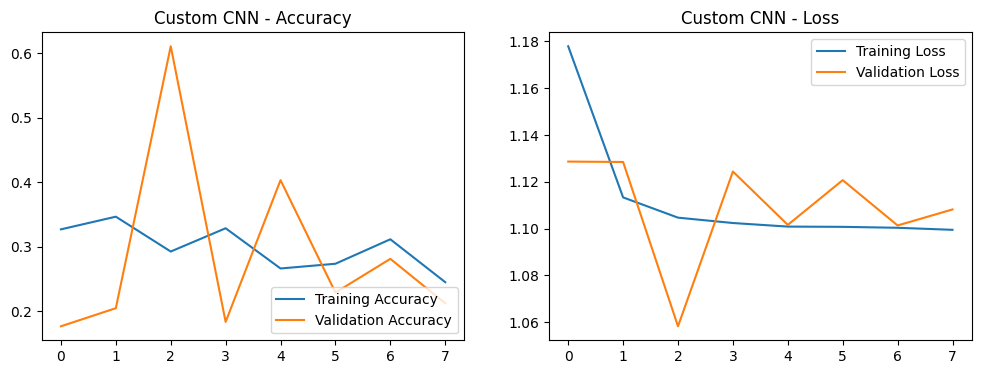

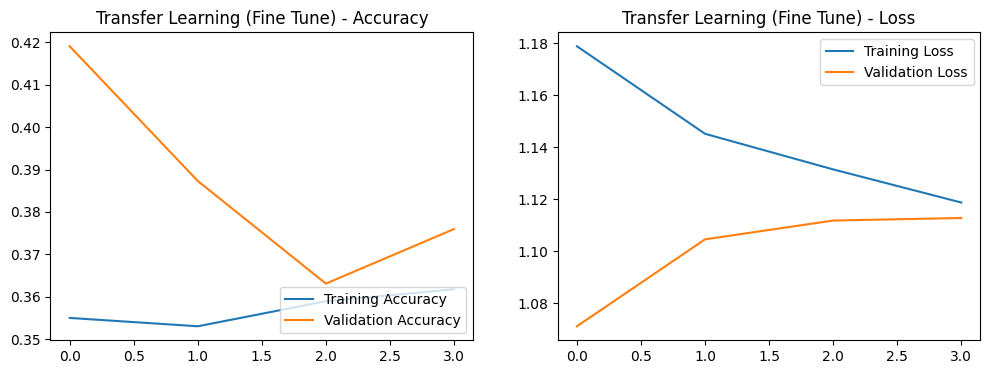

In [18]:
# @title 6. Evaluation
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')
    plt.show()

plot_history(history_scratch, "Custom CNN")
# Combine histories for plotting if needed, strictly plotting finetune phase here
plot_history(history_tl_finetune, "Transfer Learning (Fine Tune)")




--- Evaluating Custom CNN ---
              precision    recall  f1-score   support

        test       0.14      0.06      0.08       180
       train       0.65      0.88      0.75       863
         val       0.26      0.09      0.13       301

    accuracy                           0.59      1344
   macro avg       0.35      0.34      0.32      1344
weighted avg       0.49      0.59      0.52      1344



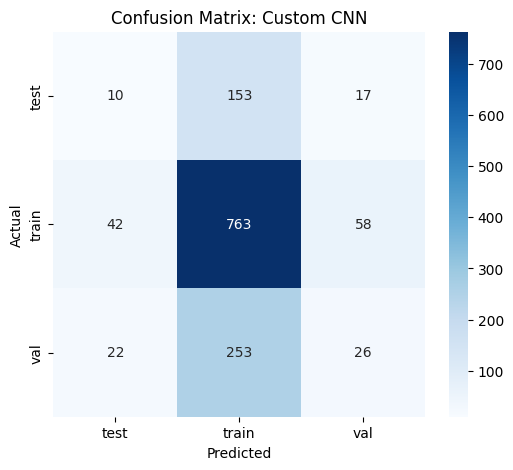


--- Evaluating Transfer Learning ---
              precision    recall  f1-score   support

        test       0.13      0.20      0.16       180
       train       0.64      0.48      0.55       863
         val       0.21      0.30      0.25       301

    accuracy                           0.40      1344
   macro avg       0.33      0.33      0.32      1344
weighted avg       0.47      0.40      0.43      1344



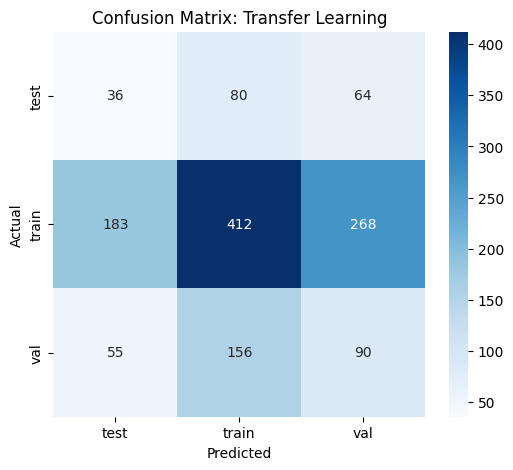

In [19]:
def evaluate_model(model, dataset, name):
    print(f"\n--- Evaluating {name} ---")
    y_true = []
    y_pred = []
    for img, label in dataset:
        y_true.extend(label.numpy())
        preds = model.predict(img, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1))

    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

evaluate_model(model_scratch, test_ds, "Custom CNN")
evaluate_model(model_tl, test_ds, "Transfer Learning")